In [39]:
import shutil, requests, os, glob
import subprocess
import geopandas as gpd
import pandas as pd
import glob
import matplotlib.pyplot as plt
import shapely
import contextily as ctx

## Download vessel activity data for first 20 days at around 0AM

In [2]:
def download_file(url):
    local_filename = os.path.join('data/california-pam/',url.split('/')[-1])
    with requests.get(url, stream=True) as r:
        with open(local_filename, 'wb') as f:
            shutil.copyfileobj(r.raw, f)

    return local_filename

In [10]:
# download vessel data for first 20 days
days = [f'{day:02d}' for day in range(1, 21)]
print(days)
urls = [f"https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_{day}.zip" for day in days]

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']


In [11]:
print(urls)

['https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_01.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_02.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_03.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_04.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_05.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_06.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_07.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_08.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_09.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_10.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_11.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_12.zip', 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_13.zip'

In [12]:
for url in urls:
    download_file(url)

In [16]:
# unzip files
for file in glob.glob('data/california-pam/AIS_2021*.zip'):
    subprocess.Popen(['unzip', file, '-d', 'data/vessel'])

Archive:  data/california-pam/AIS_2021_01_19.zip
  inflating: data/vessel/AIS_2021_01_19.csv  Archive:  data/california-pam/AIS_2021_01_20.zip
  inflating: data/vessel/AIS_2021_01_20.csv  Archive:  data/california-pam/AIS_2021_01_07.zip
  inflating: data/vessel/AIS_2021_01_07.csv  Archive:  data/california-pam/AIS_2021_01_15.zip
  inflating: data/vessel/AIS_2021_01_15.csv  Archive:  data/california-pam/AIS_2021_01_14.zip
  inflating: data/vessel/AIS_2021_01_14.csv  Archive:  data/california-pam/AIS_2021_01_01.zip
  inflating: data/vessel/AIS_2021_01_01.csv  Archive:  data/california-pam/AIS_2021_01_11.zip
  inflating: data/vessel/AIS_2021_01_11.csv  Archive:  data/california-pam/AIS_2021_01_05.zip
  inflating: data/vessel/AIS_2021_01_05.csv  Archive:  data/california-pam/AIS_2021_01_03.zip
  inflating: data/vessel/AIS_2021_01_03.csv  Archive:  data/california-pam/AIS_2021_01_12.zip
  inflating: data/vessel/AIS_2021_01_12.csv  Archive:  data/california-pam/AIS_2021_01_17.zip
  inflating

In [4]:
! pip install geopandas fiona shapely

Defaulting to user installation because normal site-packages is not writeable


# Read files

Attempt to count vessel activity within area at around 0AM

In [15]:
lat = 36.713
lon = -122.186

In [13]:
# develop function to output number of ships
def get_vessel_activity(data_path):
    # data path has date, so we can keep track of time
    date = os.path.basename(data_path)[4:-4]
    
    df = pd.read_csv(data_path, engine='pyarrow')
    query_time = df[df['BaseDateTime'].dt.hour == 0]
    query_boundingbox = f"LAT > {lat-0.25} & LAT < {lat + 0.25} & LON > {lon-0.25} & LON < {lon+0.25}"
    res = query_time.query(query_boundingbox)
    print(f"{date} has {len(res)} within bounding box")
    return res

In [16]:
results = {}
for f in glob.glob('data/vessel/AIS*.csv'):
    res =get_vessel_activity(f)
    results[f] = res

2021_01_08 has 12 within bounding box
2021_01_19 has 0 within bounding box
2021_01_01 has 0 within bounding box
2021_01_03 has 55 within bounding box
2021_01_15 has 0 within bounding box
2021_01_17 has 0 within bounding box
2021_01_14 has 0 within bounding box
2021_01_18 has 72 within bounding box
2021_01_04 has 40 within bounding box
2021_01_13 has 0 within bounding box
2021_01_11 has 0 within bounding box
2021_01_02 has 42 within bounding box
2021_01_06 has 42 within bounding box
2021_01_07 has 0 within bounding box
2021_01_09 has 0 within bounding box
2021_01_12 has 0 within bounding box
2021_01_16 has 37 within bounding box
2021_01_20 has 47 within bounding box
2021_01_05 has 53 within bounding box
2021_01_10 has 69 within bounding box


In [17]:
for d, res in results.items():
    date = os.path.basename(d)[4:-4]
    unique_vessels = len(res['MMSI'].unique())
    print(f"{date} has {unique_vessels} vessels within bounding box")

2021_01_08 has 1 vessels within bounding box
2021_01_19 has 0 vessels within bounding box
2021_01_01 has 0 vessels within bounding box
2021_01_03 has 2 vessels within bounding box
2021_01_15 has 0 vessels within bounding box
2021_01_17 has 0 vessels within bounding box
2021_01_14 has 0 vessels within bounding box
2021_01_18 has 2 vessels within bounding box
2021_01_04 has 1 vessels within bounding box
2021_01_13 has 0 vessels within bounding box
2021_01_11 has 0 vessels within bounding box
2021_01_02 has 2 vessels within bounding box
2021_01_06 has 1 vessels within bounding box
2021_01_07 has 0 vessels within bounding box
2021_01_09 has 0 vessels within bounding box
2021_01_12 has 0 vessels within bounding box
2021_01_16 has 1 vessels within bounding box
2021_01_20 has 1 vessels within bounding box
2021_01_05 has 1 vessels within bounding box
2021_01_10 has 2 vessels within bounding box


In [90]:
results['data/vessel/AIS_2021_01_10.csv'].sort_values('BaseDateTime')

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
4262,367005910,2021-01-10 00:00:21,36.57169,-121.98538,5.7,146.4,511.0,BLACKFIN,,WDI2325,60.0,NaN,19.0,8.0,NaN,NaN,B
3639,367474730,2021-01-10 00:00:47,36.93576,-122.15974,4.9,301.0,302.0,LA DOLCE VITA,,WDF6483,37.0,NaN,16.0,4.0,NaN,NaN,B
10584,367005910,2021-01-10 00:01:52,36.56987,-121.98411,4.7,147.8,511.0,BLACKFIN,,WDI2325,60.0,NaN,19.0,8.0,NaN,NaN,B
12535,367474730,2021-01-10 00:02:17,36.93644,-122.16181,4.7,285.5,292.0,LA DOLCE VITA,,WDF6483,37.0,NaN,16.0,4.0,NaN,NaN,B
21246,367005910,2021-01-10 00:03:21,36.56825,-121.98362,3.3,181.4,511.0,BLACKFIN,,WDI2325,60.0,NaN,19.0,8.0,NaN,NaN,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230840,367005910,2021-01-10 00:51:53,36.64032,-121.95759,11.4,14.3,511.0,BLACKFIN,,WDI2325,60.0,NaN,19.0,8.0,NaN,NaN,B
261015,367005910,2021-01-10 00:53:53,36.64626,-121.95561,11.3,5.2,511.0,BLACKFIN,,WDI2325,60.0,NaN,19.0,8.0,NaN,NaN,B
270505,367005910,2021-01-10 00:55:52,36.64924,-121.95475,0.6,133.0,511.0,BLACKFIN,,WDI2325,60.0,NaN,19.0,8.0,NaN,NaN,B
251533,367005910,2021-01-10 00:57:22,36.64892,-121.95473,0.4,160.9,511.0,BLACKFIN,,WDI2325,60.0,NaN,19.0,8.0,NaN,NaN,B


In [61]:
results

{'data/vessel/AIS_2021_01_08.csv':               MMSI        BaseDateTime       LAT        LON  SOG    COG  \
 2305     367799990 2021-01-08 00:00:09  36.65930 -121.96719  6.1   98.6   
 8209     367799990 2021-01-08 00:01:10  36.65901 -121.96520  5.5  100.6   
 17648    367799990 2021-01-08 00:02:39  36.65829 -121.96217  4.7  110.4   
 22786    367799990 2021-01-08 00:04:09  36.65744 -121.95936  5.4  106.9   
 30770    367799990 2021-01-08 00:05:38  36.65657 -121.95669  5.5  106.5   
 33373    367799990 2021-01-08 00:06:40  36.65596 -121.95471  5.7  112.5   
 43669    367799990 2021-01-08 00:08:09  36.65512 -121.95180  5.0  110.1   
 43701    367799990 2021-01-08 00:09:40  36.65422 -121.94875  5.8  106.7   
 61154    367799990 2021-01-08 00:13:40  36.65209 -121.94076  4.4  107.7   
 75809    367799990 2021-01-08 00:15:09  36.65150 -121.93776  5.2  114.1   
 5500303  367799990 2021-01-08 00:11:09  36.65337 -121.94569  5.0  109.7   
 5978069  367799990 2021-01-08 00:12:39  36.65258 -121

## Visualizing vessel movement

In [76]:
def plot_movement(k):
    key = f'data/vessel/AIS_{k}.csv'
    distinct_mmsis = results[key]['MMSI'].unique()
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = ['red', 'blue']
    color_count = 0
    for mmsi in distinct_mmsis:
        df = results[key].query(f"MMSI=={mmsi}")
        gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df['LON'], df['LAT']))
        geo_df = gdf['geometry']
        geo_df.crs={'init': "epsg:4326"}

        ax = geo_df.plot(ax=ax, markersize=20, marker='o', color=colors[color_count], label=f'MMSI={mmsi}')
        color_count +=1
        
    ax.plot([lon], [lat], marker='*', color='black', markersize=30, label='MARS point')
    ax.set_xlim(extent[0]-0.25, extent[1]+0.25)
    ax.set_ylim(extent[2]-0.25, extent[3]+0.25)
    ctx.add_basemap(ax, crs=geo_df.crs, source = ctx.providers.Stamen.TonerLite)
    ax.legend(loc='upper right', labelspacing=2)

/opt/conda/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


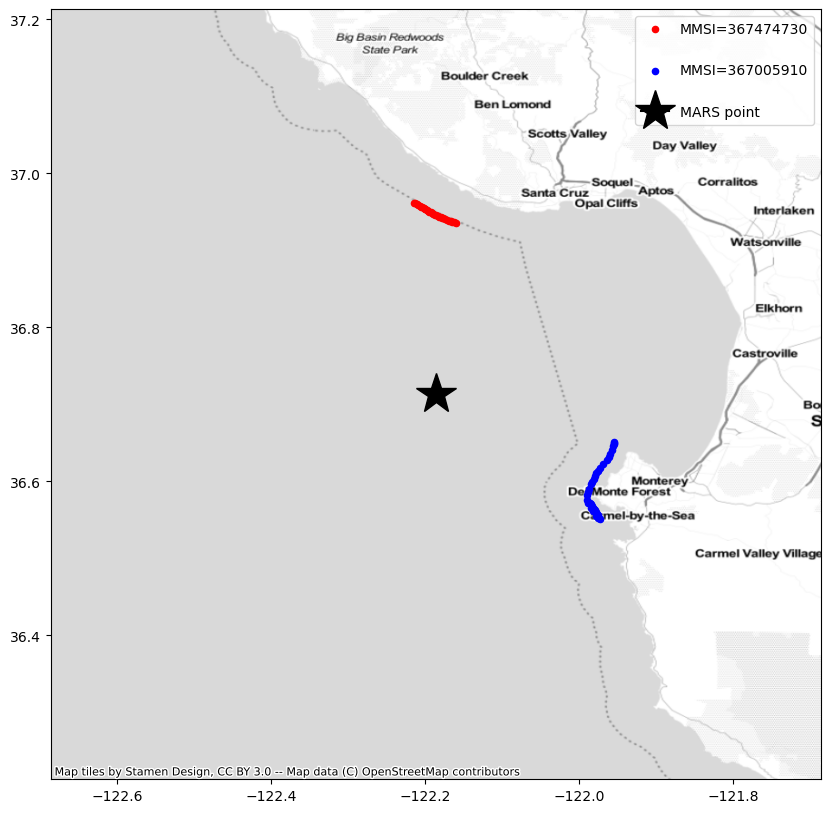

In [88]:
plot_movement('2021_01_10')

/tmp/ipykernel_1631/2587766040.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


(36.463, 36.963)

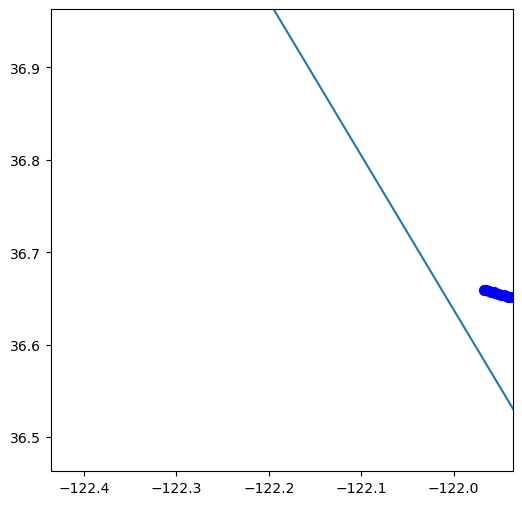

In [35]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(10, 6))
world.boundary.plot(ax=ax)
gdf.plot(ax=ax, marker='o', color='blue', markersize=50)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])

/opt/conda/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


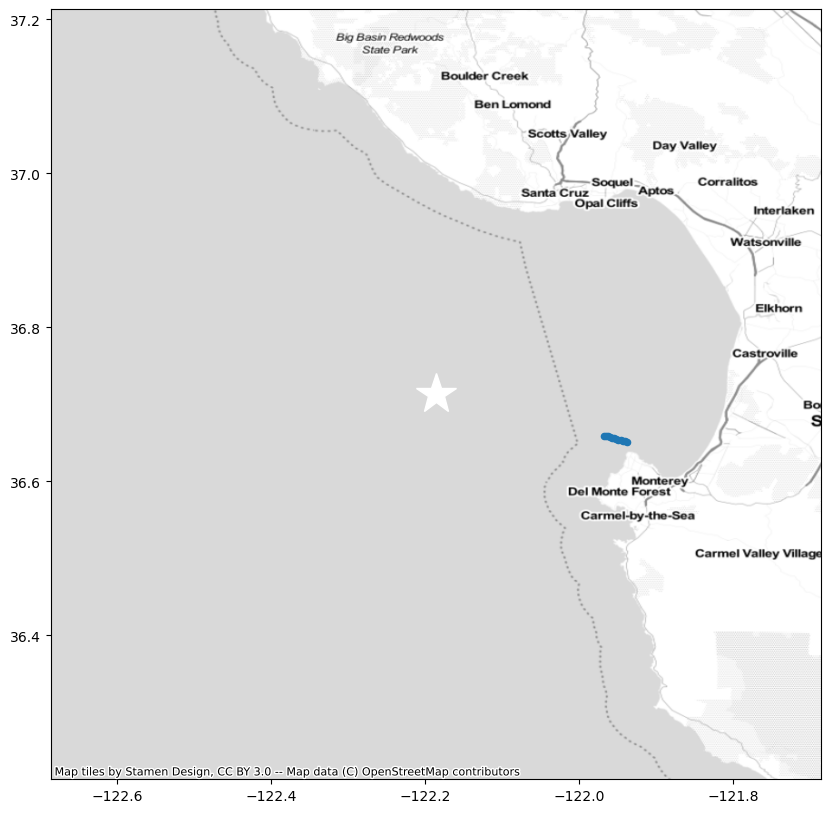

In [58]:
geo_df = gdf['geometry']
geo_df.crs={'init': "epsg:4326"}

fig, ax = plt.subplots(figsize=(10, 10))
ax = geo_df.plot(ax=ax, markersize=20, marker='o')
ax.set_xlim(extent[0]-0.25, extent[1]+0.25)
ax.set_ylim(extent[2]-0.25, extent[3]+0.25)
ax.plot([lon], [lat], marker='*', color='white', markersize=30)
ctx.add_basemap(ax, crs=geo_df.crs, source = ctx.providers.Stamen.TonerLite)


In [52]:
type(ax)

matplotlib.axes._axes.Axes